# 1. Import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , StandardScaler , LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.metrics import mean_absolute_error , accuracy_score , mean_squared_error, r2_score , mean_squared_error as root_mean_squared_error

# 2. Load Data

In [5]:
df = pd.read_csv('insurance_dirty.csv')
print(f"Initial shape: {df.shape}")
df.head()

Initial shape: (1388, 7)


,age,sex,bmi,children,smoker,region,charges
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18.0,male,33.77,1.0,no,southeast,1725.5523
2,28.0,male,33.0,3.0,no,southeast,4449.462
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.88,0.0,no,northwest,3866.8552


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1315 non-null   object 
 1   sex       1315 non-null   object 
 2   bmi       1315 non-null   object 
 3   children  1315 non-null   float64
 4   smoker    1315 non-null   object 
 5   region    1315 non-null   object 
 6   charges   1315 non-null   object 
dtypes: float64(1), object(6)
memory usage: 76.0+ KB


# 4. Check Missing Values

In [7]:
print("Missing values per column:")
print(df.isnull().sum())
print("\nMissing values percentage:")
print((df.isnull().sum() / len(df) * 100).round(2))

Missing values per column:
age         73
sex         73
bmi         73
children    73
smoker      73
region      73
charges     73
dtype: int64

Missing values percentage:
age         5.26
sex         5.26
bmi         5.26
children    5.26
smoker      5.26
region      5.26
charges     5.26
dtype: float64


# 5. Remove Empty Rows and Duplicates

In [8]:
df = df.dropna(how='all')
print(f"After removing empty rows: {df.shape}")

df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")

After removing empty rows: (1315, 7)
After removing duplicates: (1269, 7)


# 6. Clean Age Column

In [9]:
def clean_age(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.lower() == 'twenty':
            return 20
        try:
            return float(value)
        except:
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

df['age'] = df['age'].apply(clean_age)
print("Age column cleaned")
print(f"Age missing values: {df['age'].isnull().sum()}")

Age column cleaned
Age missing values: 0


# 7. Clean BMI Column

In [10]:

def clean_bmi(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value == '??' or value.strip() == '':
            return np.nan
        try:
            val = float(value)
            if val > 60 or val < 10:
                return np.nan
            return val
        except:
            return np.nan
    try:
        val = float(value)
        if val > 60 or val < 10:
            return np.nan
        return val
    except:
        return np.nan

df['bmi'] = df['bmi'].apply(clean_bmi)
print("BMI column cleaned")
print(f"BMI missing values: {df['bmi'].isnull().sum()}")

BMI column cleaned
BMI missing values: 2


# 8. Clean Charges Column

In [11]:

def clean_charges(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.lower() == 'free' or value.strip() == '':
            return np.nan
        try:
            val = float(value)
            if val > 100000 or val < 1000:
                return np.nan
            return val
        except:
            return np.nan
    try:
        val = float(value)
        if val > 100000 or val < 1000:
            return np.nan
        return val
    except:
        return np.nan

df['charges'] = df['charges'].apply(clean_charges)
print("Charges column cleaned")
print(f"Charges missing values: {df['charges'].isnull().sum()}")

Charges column cleaned
Charges missing values: 2


# 9. Clean Children and Categorical Columns

In [12]:

df['children'] = pd.to_numeric(df['children'], errors='coerce')

# Clean categorical columns
if df['sex'].dtype == 'object':
    df['sex'] = df['sex'].str.strip().str.lower()
if df['smoker'].dtype == 'object':
    df['smoker'] = df['smoker'].str.strip().str.lower()
if df['region'].dtype == 'object':
    df['region'] = df['region'].str.strip().str.lower()

print("Children and categorical columns cleaned")
print(f"\nUnique values:")
print(f"Sex: {df['sex'].unique()}")
print(f"Smoker: {df['smoker'].unique()}")
print(f"Region: {df['region'].unique()}")

Children and categorical columns cleaned

Unique values:
Sex: ['male' 'female']
Smoker: ['no' 'yes']
Region: ['southeast' 'northwest' 'northeast' 'southwest']


# 10. Handle Missing Values

In [15]:
df = df.dropna(subset=['age', 'charges'])
print(f"After removing rows with missing age/charges: {df.shape}")

imputer = SimpleImputer(strategy='median')
df[['bmi', 'children']] = imputer.fit_transform(df[['bmi', 'children']])

print(f"\nMissing values after imputation:")
print(df.isnull().sum())

After removing rows with missing age/charges: (1267, 7)

Missing values after imputation:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# Cell 11: Convert Data Types

In [14]:
df['age'] = df['age'].astype(float)
df['bmi'] = df['bmi'].astype(float)
df['children'] = df['children'].astype(int)
df['charges'] = df['charges'].astype(float)

print("Data types converted successfully")
df.dtypes

Data types converted successfully


age         float64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

# 12. Validate and Fill Categorical Values

In [16]:

valid_sex = ['male', 'female']
valid_smoker = ['yes', 'no']
valid_regions = ['northeast', 'northwest', 'southeast', 'southwest']


df = df[df['sex'].isin(valid_sex) | df['sex'].isna()]
df = df[df['smoker'].isin(valid_smoker) | df['smoker'].isna()]
df = df[df['region'].isin(valid_regions) | df['region'].isna()]


if df['sex'].isna().any():
    df['sex'] = df['sex'].fillna(df['sex'].mode()[0] if len(df['sex'].mode()) > 0 else 'male')
if df['smoker'].isna().any():
    df['smoker'] = df['smoker'].fillna(df['smoker'].mode()[0] if len(df['smoker'].mode()) > 0 else 'no')
if df['region'].isna().any():
    df['region'] = df['region'].fillna(df['region'].mode()[0] if len(df['region'].mode()) > 0 else 'southeast')

print(f"Final shape: {df.shape}")
print(f"\nFinal missing values:")
print(df.isnull().sum())

Final shape: (1267, 7)

Final missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# 13. Summary Statistics

In [17]:
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
               age          bmi     children       charges
count  1267.000000  1267.000000  1267.000000   1267.000000
mean     39.224152    30.625284     1.082873  13238.588597
std      14.027009     6.114596     1.195138  12082.524268
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.220000     0.000000   4749.061450
50%      39.000000    30.305000     1.000000   9361.326800
75%      51.000000    34.580000     2.000000  16516.743675
max      64.000000    53.130000     5.000000  63770.428010


# 14. Encode Categorical Variables with OneHotEncoder

In [18]:
# Cell 14: Encode Categorical Variables with OneHotEncoder
df_encoded = df.copy()

# Use LabelEncoder for binary categorical variables (sex, smoker)
label_encoders = {}
binary_cols = ['sex', 'smoker']

for col in binary_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Use OneHotEncoder for 'region' (multi-category variable)
ohe = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity

# Apply OneHotEncoder to 'region'
region_encoded = ohe.fit_transform(df_encoded[['region']])

# Create DataFrame with encoded region columns
region_cols = ohe.get_feature_names_out(['region'])
region_df = pd.DataFrame(region_encoded, columns=region_cols, index=df_encoded.index)

# Drop original 'region' column and concatenate encoded columns
df_encoded = df_encoded.drop('region', axis=1)
df_encoded = pd.concat([df_encoded, region_df], axis=1)

print(f"\nRegion encoding created columns: {list(region_cols)}")
print(f"\nFinal encoded dataframe shape: {df_encoded.shape}")
print(f"Columns: {list(df_encoded.columns)}")

sex encoding: {'female': np.int64(0), 'male': np.int64(1)}
smoker encoding: {'no': np.int64(0), 'yes': np.int64(1)}

Region encoding created columns: ['region_northwest', 'region_southeast', 'region_southwest']

Final encoded dataframe shape: (1267, 9)
Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


# 15. Display Encoded Data

In [19]:
print("Encoded data preview:")
df_encoded.head(10)

Encoded data preview:


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
1,18.0,1,33.770,1.0,0,1725.55230,0.0,1.0,0.0
2,28.0,1,33.000,3.0,0,4449.46200,0.0,1.0,0.0
3,33.0,1,22.705,0.0,0,21984.47061,1.0,0.0,0.0
4,32.0,1,28.880,0.0,0,3866.85520,1.0,0.0,0.0
5,31.0,0,30.305,0.0,0,3756.62160,0.0,1.0,0.0
6,46.0,0,33.440,1.0,0,8240.58960,0.0,1.0,0.0
8,37.0,1,29.830,2.0,0,6406.41070,0.0,0.0,0.0
9,60.0,0,25.840,0.0,0,28923.13692,1.0,0.0,0.0
10,20.0,1,26.220,0.0,0,2721.32080,0.0,0.0,0.0
11,62.0,0,26.290,0.0,1,27808.72510,0.0,1.0,0.0


# 16. Scale Numerical Features

In [20]:
numerical_cols = ['age', 'bmi', 'children', 'charges']
scaler = StandardScaler()

df_encoded_scaled = df_encoded.copy()
df_encoded_scaled[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

print(f"Scaled data shape: {df_encoded_scaled.shape}")
print(f"Columns after scaling: {list(df_encoded_scaled.columns)}")
df_encoded_scaled.head(10)

Scaled data shape: (1267, 9)
Columns after scaling: ['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
1,-1.513689,1,0.514500,-0.069369,0,-0.953243,0.0,1.0,0.0
2,-0.800497,1,0.388522,1.604738,0,-0.727712,0.0,1.0,0.0
3,-0.443901,1,-1.295819,-0.906423,0,0.724131,1.0,0.0,0.0
4,-0.515221,1,-0.285542,-0.906423,0,-0.775950,1.0,0.0,0.0
5,-0.586540,0,-0.052401,-0.906423,0,-0.785077,0.0,1.0,0.0
6,0.483248,0,0.460509,-0.069369,0,-0.413819,0.0,1.0,0.0
8,-0.158625,1,-0.130115,0.767685,0,-0.565683,0.0,0.0,0.0
9,1.481717,0,-0.782909,-0.906423,0,1.298631,1.0,0.0,0.0
10,-1.371051,1,-0.720738,-0.906423,0,-0.870797,0.0,0.0,0.0
11,1.624355,0,-0.709286,-0.906423,1,1.206361,0.0,1.0,0.0


# 17. Visualize Correlation Matrix

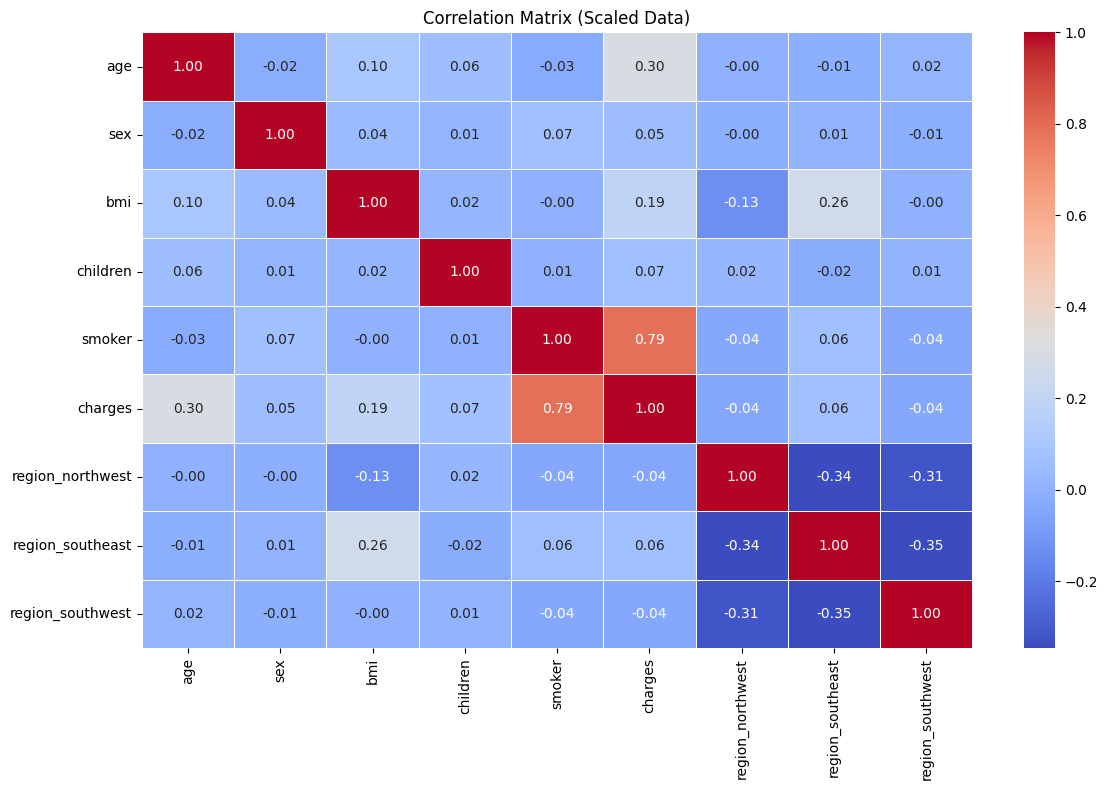

In [21]:
plt.figure(figsize=(12, 8))
correlation_matrix = df_encoded_scaled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Scaled Data)')
plt.tight_layout()
plt.show()

# 18. Distribution Plots

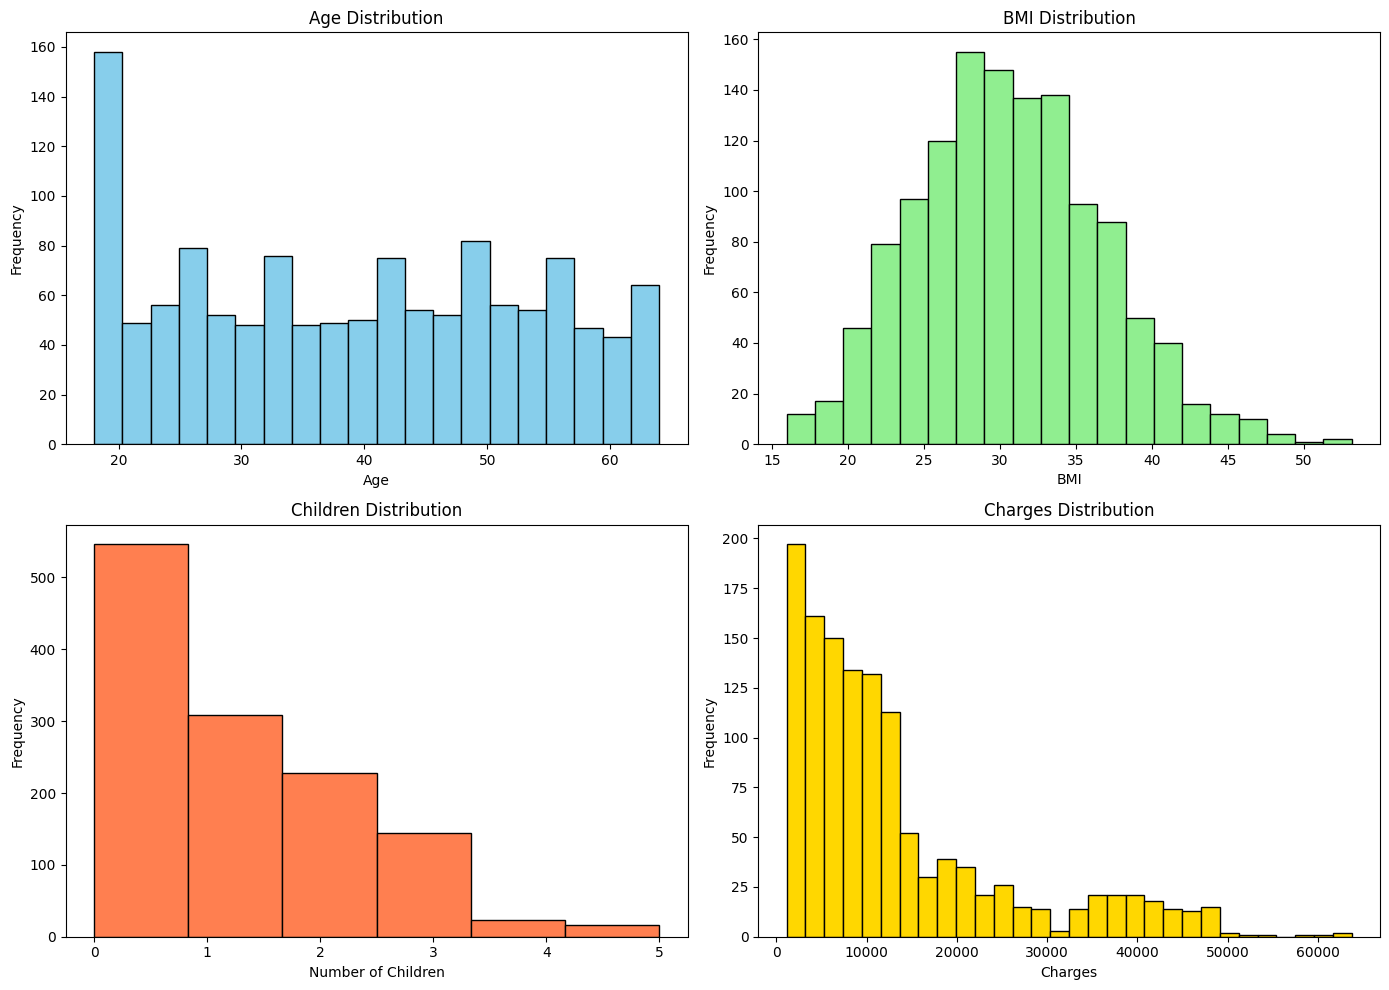

In [22]:
# Cell 18: Distribution Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(df['age'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# BMI distribution
axes[0, 1].hist(df['bmi'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('BMI Distribution')
axes[0, 1].set_xlabel('BMI')
axes[0, 1].set_ylabel('Frequency')

# Children distribution
axes[1, 0].hist(df['children'], bins=6, color='coral', edgecolor='black')
axes[1, 0].set_title('Children Distribution')
axes[1, 0].set_xlabel('Number of Children')
axes[1, 0].set_ylabel('Frequency')

# Charges distribution
axes[1, 1].hist(df['charges'], bins=30, color='gold', edgecolor='black')
axes[1, 1].set_title('Charges Distribution')
axes[1, 1].set_xlabel('Charges')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#  19. Categorical Variables Distribution

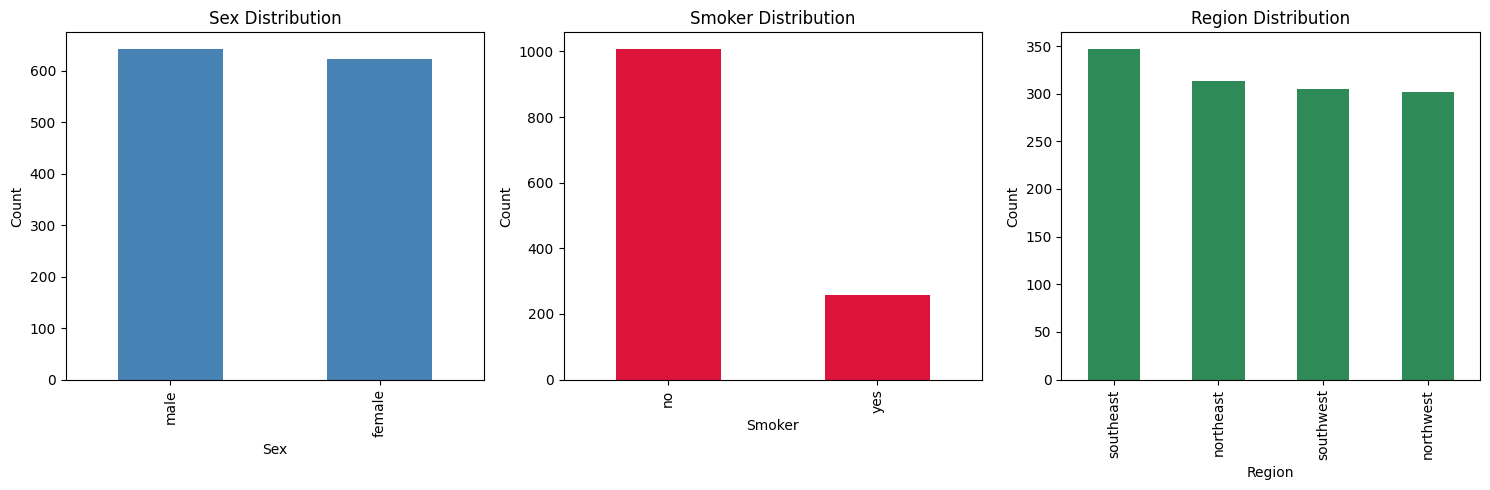

In [23]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sex distribution
df['sex'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Sex Distribution')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')

# Smoker distribution
df['smoker'].value_counts().plot(kind='bar', ax=axes[1], color='crimson')
axes[1].set_title('Smoker Distribution')
axes[1].set_xlabel('Smoker')
axes[1].set_ylabel('Count')

# Region distribution
df['region'].value_counts().plot(kind='bar', ax=axes[2], color='seagreen')
axes[2].set_title('Region Distribution')
axes[2].set_xlabel('Region')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 20. Prepare X and y

In [24]:

# Features (X) - all columns except charges
X = df_encoded_scaled.drop('charges', axis=1)

# Target (y) - original (unscaled) charges
y = df['charges']

print("X (features) shape:", X.shape)
print("X columns:", list(X.columns))
print("\ny (target) shape:", y.shape)
print("\nX (features) preview:")
print(X.head())
print("\ny (target) preview:")
print(y.head())

X (features) shape: (1267, 8)
X columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']

y (target) shape: (1267,)

X (features) preview:
        age  sex       bmi  children  smoker  region_northwest  \
1 -1.513689    1  0.514500 -0.069369       0               0.0   
2 -0.800497    1  0.388522  1.604738       0               0.0   
3 -0.443901    1 -1.295819 -0.906423       0               1.0   
4 -0.515221    1 -0.285542 -0.906423       0               1.0   
5 -0.586540    0 -0.052401 -0.906423       0               0.0   

   region_southeast  region_southwest  
1               1.0               0.0  
2               1.0               0.0  
3               0.0               0.0  
4               0.0               0.0  
5               1.0               0.0  

y (target) preview:
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
5     3756.62160
Name: charges, dtype: float64


# 21. Train-Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target size: {y_train.shape}")
print(f"Test target size: {y_test.shape}")

Training set size: (1013, 8)
Test set size: (254, 8)

Training target size: (1013,)
Test target size: (254,)


#  22. Build Random Forest Model

In [26]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully!")

Random Forest model trained successfully!


# 23. Make Predictions

In [27]:
y_pred = rf_model.predict(X_test)

print("Predictions made successfully!")
print(f"First 5 predictions: {y_pred[:5]}")
print(f"First 5 actual values: {y_test.values[:5]}")

Predictions made successfully!
First 5 predictions: [21773.29095722  5731.71549872 12927.66959748 14070.3926106
  5728.50766022]
First 5 actual values: [22462.04375  3227.1211  11454.0215   9447.3824   4661.28635]


# 24. Model Evaluation Metrics

In [28]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("=" * 50)
print("MODEL EVALUATION METRICS")
print("=" * 50)
print(f"R² Score: {r2 * 100:.2f}%")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")
print("=" * 50)

MODEL EVALUATION METRICS
R² Score: 84.38%
RMSE: $4,910.89
MAE: $2,636.91


# 25. Feature Importance

Feature Importance:
            feature  importance
4            smoker    0.673567
2               bmi    0.175691
0               age    0.129201
3          children    0.013517
1               sex    0.002457
5  region_northwest    0.002236
6  region_southeast    0.002026
7  region_southwest    0.001305


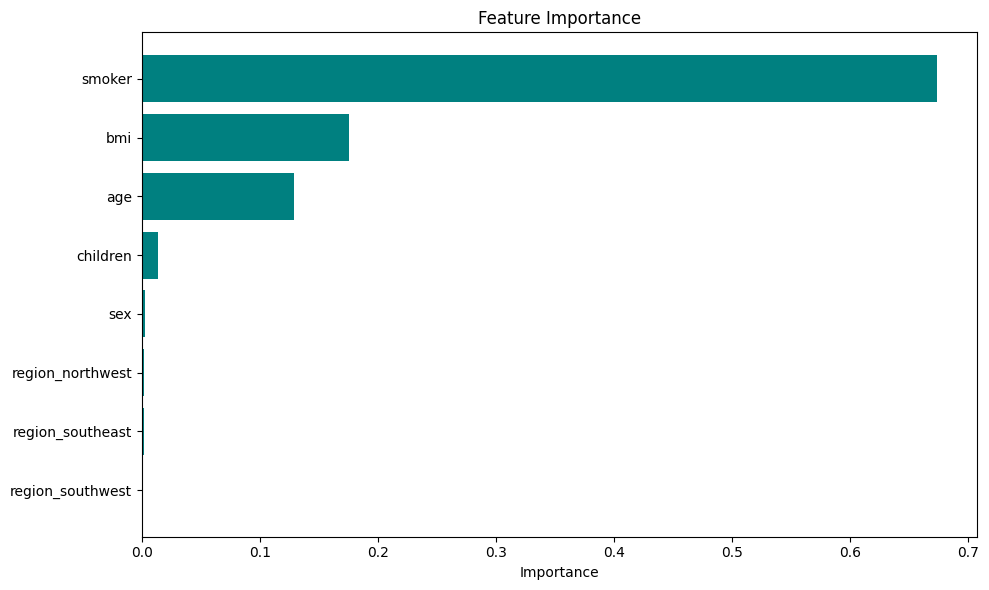

In [29]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='teal')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 26. Actual vs Predicted Plot

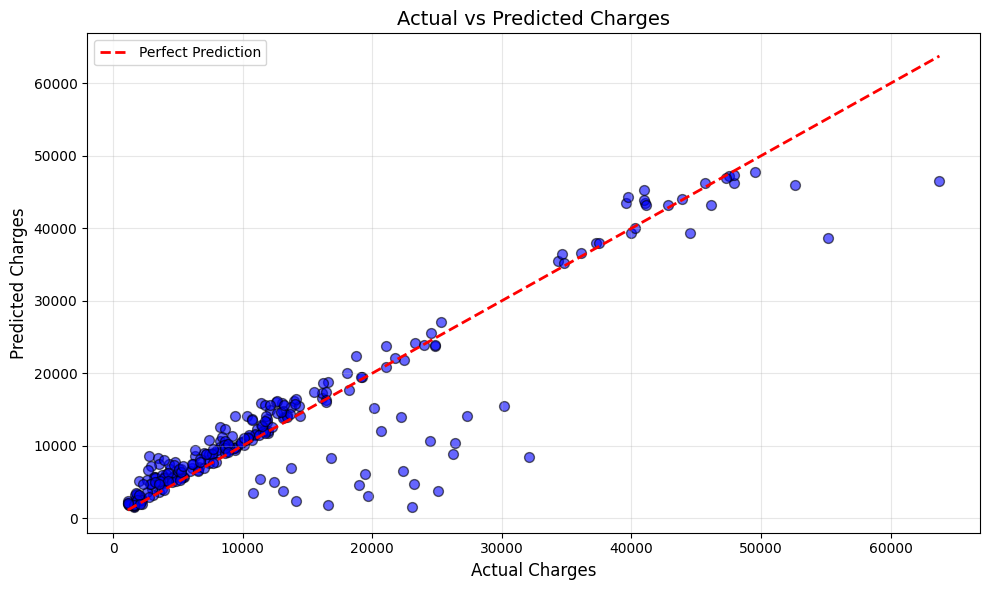

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolors='k', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Charges', fontsize=12)
plt.ylabel('Predicted Charges', fontsize=12)
plt.title('Actual vs Predicted Charges', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 28: Prediction Results Table

In [31]:
results_df = pd.DataFrame({
    'Actual Charges': y_test.values,
    'Predicted Charges': y_pred,
    'Difference': y_test.values - y_pred,
    'Absolute Error': np.abs(y_test.values - y_pred)
})

print("Prediction Results (First 15 rows):")
print(results_df.head(15))

Prediction Results (First 15 rows):
    Actual Charges  Predicted Charges    Difference  Absolute Error
0      22462.04375       21773.290957    688.752793      688.752793
1       3227.12110        5731.715499  -2504.594399     2504.594399
2      11454.02150       12927.669597  -1473.648097     1473.648097
3       9447.38240       14070.392611  -4623.010211     4623.010211
4       4661.28635        5728.507660  -1067.221310     1067.221310
5       6117.49450        6877.214959   -759.720459      759.720459
6      14001.13380       16200.768062  -2199.634262     2199.634262
7      23082.95533        1495.289197  21587.666133    21587.666133
8       3556.92230        3670.660916   -113.738616      113.738616
9      23306.54700       24118.275794   -811.728794      811.728794
10     49577.66240       47784.694982   1792.967418     1792.967418
11      3861.20965        4850.323729   -989.114079      989.114079
12     19673.33573        3120.947477  16552.388253    16552.388253
13     47928

# 29. Cross-Validation

In [32]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, 
                            scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)

print("=" * 50)
print("CROSS-VALIDATION RESULTS")
print("=" * 50)
print(f"CV RMSE scores: {cv_rmse}")
print(f"Mean CV RMSE: ${cv_rmse.mean():,.2f}")
print(f"Std CV RMSE: ${cv_rmse.std():,.2f}")
print("=" * 50)

CROSS-VALIDATION RESULTS
CV RMSE scores: [4180.21887313 4612.27154973 4163.22971098 4671.01260641 5023.0246931 ]
Mean CV RMSE: $4,529.95
Std CV RMSE: $324.53


#  30: Save Processed Data

In [33]:
df_encoded.to_csv('insurance_encoded.csv', index=False)
print("Encoded data saved to 'insurance_encoded.csv'")

# Save encoded and scaled data
df_encoded_scaled.to_csv('insurance_encoded_scaled.csv', index=False)
print("Encoded and scaled data saved to 'insurance_encoded_scaled.csv'")

Encoded data saved to 'insurance_encoded.csv'
Encoded and scaled data saved to 'insurance_encoded_scaled.csv'


# 32. Model Summary

In [34]:

print("=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)
print(f"Dataset Shape: {df.shape}")
print(f"Features Used: {list(X.columns)}")
print(f"Model: Random Forest Regressor")
print(f"Number of Trees: 200")
print(f"Max Depth: 10")
print(f"\nPerformance Metrics:")
print(f"  R² Score: {r2 * 100:.2f}%")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE: ${mae:,.2f}")
print(f"  CV RMSE Mean: ${cv_rmse.mean():,.2f}")
print("=" * 60)

FINAL MODEL SUMMARY
Dataset Shape: (1267, 7)
Features Used: ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']
Model: Random Forest Regressor
Number of Trees: 200
Max Depth: 10

Performance Metrics:
  R² Score: 84.38%
  RMSE: $4,910.89
  MAE: $2,636.91
  CV RMSE Mean: $4,529.95


# 33. Predict Charges for New / Unseen Data (Interactive)

In [ ]:


def predict_new_patient():
    print("=== Insurance Charge Predictor ===\n")
    
   
    age      = int(input("Age (18-64): "))
    sex      = input("Sex (male/female): ").strip().lower()
    bmi      = float(input("BMI (e.g. 27.5): "))
    children = int(input("Number of children: "))
    smoker   = input("Smoker (yes/no): ").strip().lower()
    region   = input("Region (northeast/northwest/southeast/southwest): ").strip().lower()
    
    
    new_patient = pd.DataFrame({
        'age': [age],
        'sex': [sex],
        'bmi': [bmi],
        'children': [children],
        'smoker': [smoker],
        'region': [region]
    })
    
    try:
        new_patient['sex']    = label_encoder_sex.transform(new_patient['sex'])      
        new_patient['smoker'] = labelEncoder_smoker.transform(new_patient['smoker']) 
        X_new = ct.transform(new_patient)                                         
    except Exception as e:
        print(f"\nError: {e}")
        print("   → Make sure you typed: male/female, yes/no, and region exactly as shown")
        return
    
    # Predict
    prediction = best_model.predict(X_new)[0]
    
    print("\n" + "="*60)
    print(f"   PREDICTED INSURANCE CHARGE: ${prediction:,.2f}")
    print("="*60)
    
    # Optional real value comparison
    if input("\nDo you know the actual charge? (y/n): ").lower() == 'y':
        actual = float(input("Enter actual charge: $"))
        diff = abs(prediction - actual)
        print(f"\n   Actual charge : ${actual:,.2f}")
        print(f"   Difference    : ${diff:,.2f}")
        
        plt.figure(figsize=(6,4))
        plt.bar(['Predicted', 'Actual'], [prediction, actual], color=['#3498db', '#e74c3c'])
        plt.title('Predicted vs Actual Charge')
        plt.ylabel('Charge ($)')
        for i, v in enumerate([prediction, actual]):
            plt.text(i, v + 300, f"${v:,.0f}", ha='center', fontweight='bold', fontsize=11)
        plt.show()


predict_new_patient()

=== Insurance Charge Predictor ===


Error: name 'label_encoder_sex' is not defined
   → Check spelling: male/female, yes/no, northeast/northwest/etc.
